## Results Generation Notebook
This notebook can be run from start to finish without any user intervention. It loops through the datasets defined in `DATASETS` and fits each classifier listed in `CLASSIFIERS`. In the final cell eval metrics are generated for each classifier-dataset combination. 

Classifier definitions can be found in `classifiers.py`

Data loaders can be found in `data.py`

Evaluation metric definitions can be found in `eval.py`

In [1]:
from classifiers import ConformalPredictor, WCRF, RandomForest, NaiveCautiousClassifier, FuzzyRandomForest
from data import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from eval import conformal_pred_eval, wcrf_eval, evaluate_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import json
from fuzzytrees.fdt_base import FuzzificationOptions, CRITERIA_FUNC_CLF
from fuzzytrees.fdts import FuzzyCARTClassifier,FuzzyID3Classifier, FuzzyC45Classifier



                               Environment Configuration Information                                
Number of CPU cores available:
                                                                                                  20
Number of CPU cores requested:
                                                                                                  20
(EXP) Comparison experiments:
                                                                             FF3 -- f3_ds_vs_orig_ds
                                                                             FF4 -- f4_ds_vs_orig_ds
                                                                             FF5 -- f5_ds_vs_orig_ds
                                                                                FUZZY -- fdt_vs_nfdt
                                                                         BOOSTING -- fgbdt_vs_nfgbdt
(EXP) Search optimal parameters:
                                            FUZZY_REG_VS_ERR_ON_N_C

In [2]:
DATASETS = ["german_credit_data", "heart_disease_data", "breast_cancer_data", "compas_data"]
CLASSIFIERS = ['RandomForest', 'WCRF', 'ConformalPredictor', 'NaiveCautiousClassifier']

## Load pre-processed data

In [3]:
datasets = {}
for dataset_name in DATASETS:
    print(f"Processing dataset: {dataset_name}")
    data = load_dataset(dataset_name)
    datasets[dataset_name] = data

Processing dataset: german_credit_data
Processing dataset: heart_disease_data
Processing dataset: breast_cancer_data
Processing dataset: compas_data


## Initialize models

In [4]:
classifiers = {}
for dataset_name in DATASETS:
    X_train, X_calib, X_test, y_train, y_calib, y_test = datasets[dataset_name]["train"], datasets[dataset_name]["calib"], datasets[dataset_name]["test"], datasets[dataset_name]["train_labels"],datasets[dataset_name]["calib_labels"],datasets[dataset_name]["test_labels"]
    # Regular RF
    rfc = RandomForest(X_train, y_train)
    # Conformal RF
    cpc = ConformalPredictor()
    # Weighted Cautiouse Random Forest
    wcrf = WCRF(s=1,gamma=1,labda=5)
    # Naive Cautious Classifier
    ncc = NaiveCautiousClassifier(X_train, y_train, 0.7)
    #Fuzzy Random Forest
    frf = FuzzyRandomForest(disable_fuzzy=False,fuzzification_options=FuzzificationOptions(n_conv=5),criterion_func=CRITERIA_FUNC_CLF["gini"])
    classifiers[str(dataset_name)+'__RandomForest'] = rfc
    classifiers[str(dataset_name)+'__ConformalPredictor'] = cpc
    classifiers[str(dataset_name)+'__WCRF'] = wcrf
    classifiers[str(dataset_name)+'__NaiveCautiousClassifier'] = ncc
    classifiers[str(dataset_name)+'__FuzzyRandomForest'] = frf



## Fit models

This cell is used to determine the optimal hyperparameters for our five models, and can take a few hours to run. All relevant parameters have been found and stored in the `configs` directory so skipping it will not create any issues.

In [ ]:
## Get model params
## ONLY RUN THIS IF YOU NEED TO RUN GRID SEARCH
## OTHERWISE JUST READ PARAMS FROM CONFIG FILE
## NOTE this took me ~1hr to run, so once you get params dont re-run this, just run the below!!
## Might be nice to just load params into a config file. 
best_params_per_dataset = {} 
wcrf_params_per_dataset = {}
for classifier in classifiers.keys():
    # Vanilla Random Forest
    dataset_name = classifier.split('__')[0]
    if 'FuzzyRandomForest' in str(classifier):
        if dataset_name not in wcrf_params_per_dataset:
            classifiers[classifier].gridSearch(dataset_name,datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'], datasets[dataset_name]['test'], datasets[dataset_name]['test_labels'])
            wcrf_params_per_dataset[dataset_name] = True
        classifiers[classifier].fit(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
    elif "RandomForest" in str(classifier): 
        if dataset_name not in best_params_per_dataset:
            best_params = classifiers[classifier].gridSearch()
            best_params_per_dataset[dataset_name] = best_params
        classifiers[classifier].fit(best_params_per_dataset[dataset_name])
    # Conformal RF
    elif "ConformalPredictor" in str(classifier):
        if dataset_name not in best_params_per_dataset:
            best_params = classifiers[classifier].gridSearch(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
            best_params_per_dataset[dataset_name] = best_params
        classifiers[classifier].fit(best_params_per_dataset[dataset_name], datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'], datasets[dataset_name]['calib'], datasets[dataset_name]['calib_labels'])
    # Weighted Cautiouse Random Forest
    elif "WCRF" in str(classifier):
        if dataset_name not in wcrf_params_per_dataset:
            classifiers[classifier].gridSearch(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'], datasets[dataset_name]['test'], datasets[dataset_name]['test_labels'])
            wcrf_params_per_dataset[dataset_name] = True
        classifiers[classifier].fit(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
        classifiers[classifier].fit_w(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
    elif "NaiveCautiousClassifier" in str(classifier):
        if dataset_name not in best_params_per_dataset:
            best_params = classifiers[classifier].gridSearch()
            best_params_per_dataset[dataset_name] = best_params
        classifiers[classifier].fit(best_params_per_dataset[dataset_name])
    else: 
        raise ValueError(f"Classifier: {classifier} not found")

german_credit_data
Writing to file
Written
heart_disease_data
Writing to file
Written
breast_cancer_data
Writing to file
Written
compas_data
Writing to file
Written


### Load model parameters and fit each model

In [ ]:
def load_config(file_path, dataset_name):
    with open(file_path, 'r') as f:
        config = json.load(f)
    return config.get(dataset_name, None)

config_path = './configs/rf_param_config.json'
config_path_wcrf = './configs/wcrf_params_config_file.json'
config_path_frf = './configs/frf_param_config.json'

# Fit classifier with already obtained models params 
for classifier in classifiers.keys():
    dataset_name = classifier.split('__')[0]
    best_params = load_config(config_path, dataset_name)
    #Fuzzy Random Forest
    if 'FuzzyRandomForest' in str(classifier):
        params = load_config(config_path_frf,dataset_name)
        cl = params['fdt_class']
        if cl =='ID3':
            classifiers[classifier].fdt_class = FuzzyID3Classifier
        elif cl == 'CART':
            classifiers[classifier].fdt_class = FuzzyCARTClassifier
        elif cl == 'C45':
            classifiers[classifier].fdt_class = FuzzyC45Classifier
        classifiers[classifier].n_estimators = params['n_estimators']
        classifiers[classifier].max_depth=params['max_depth']
        classifiers[classifier].min_samples_split = params['min_samples_split']
        classifiers[classifier].min_impurity_split = params['min_impurity_split']
        classifiers[classifier].build_estimators()
        classifiers[classifier].fit(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
    # Vanilla Random Forest
    elif "RandomForest" in str(classifier): 
        classifiers[classifier].fit(best_params)
    # Conformal RF
    elif "ConformalPredictor" in str(classifier):
        classifiers[classifier].fit(best_params, datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'], datasets[dataset_name]['calib'], datasets[dataset_name]['calib_labels'])
    # Weighted Cautiouse Random Forest
    elif "WCRF" in str(classifier):
        params = load_config(config_path_wcrf, dataset_name)
        labda = params['labda']
        gamma = params['gamma']
        s = params['s']
        classifiers[classifier].labda = labda
        classifiers[classifier].gamma = gamma
        classifiers[classifier].s = s
        classifiers[classifier].fit(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
        classifiers[classifier].fit_w(datasets[dataset_name]['train'], datasets[dataset_name]['train_labels'])
    elif "NaiveCautiousClassifier" in str(classifier):
        classifiers[classifier].fit(best_params)
    else: 
        raise ValueError(f"Classifier: {classifier} not found")

{'n_estimators': 50, 'max_depth': 1, 'min_samples_split': 2, 'min_impurity_split': 1e-07, 'fdt_class': 'CART'}
{'n_estimators': 50, 'max_depth': 1, 'min_samples_split': 5, 'min_impurity_split': 1e-07, 'fdt_class': 'CART'}
{'n_estimators': 50, 'max_depth': 1, 'min_samples_split': 5, 'min_impurity_split': 1e-06, 'fdt_class': 'CART'}
{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 5, 'min_impurity_split': 1e-05, 'fdt_class': 'CART'}


## Run Eval

In [11]:
for classifier in classifiers.keys():
    classifier_name = classifier.split("__")[1]
    dataset_name = classifier.split("__")[0]
    print("=" * 50)
    print(f'Evaluation Results for Classifier: {classifier_name}')
    print(f'Dataset: {dataset_name}')
    print('-' * 50)
    model_eval = evaluate_model(
        classifier_name, 
        datasets[dataset_name]['test'], 
        datasets[dataset_name]['test_labels'], 
        classifiers[classifier]
    )
    if isinstance(model_eval, dict):
        for metric, value in model_eval.items():
            print(f"{metric.replace('_', ' ').capitalize()}: {value}")
    else:
        print(f'Accuracy:  {model_eval}')
    print('='*50)


Evaluation Results for Classifier: RandomForest
Dataset: german_credit_data
--------------------------------------------------
U65 score: 74.0
Single set accuracy: 74.0
Determinacy: 100.0
Abstention: 0.0
Evaluation Results for Classifier: ConformalPredictor
Dataset: german_credit_data
--------------------------------------------------
U65 score: 74.52
Single set accuracy: 87.95
Determinacy: 41.5
Abstention: 58.5
Evaluation Results for Classifier: WCRF
Dataset: german_credit_data
--------------------------------------------------
U65 score: 75.5
Single set accuracy: 75.5
Determinacy: 100.0
Precise accuracy: 76.5
Abstention: 0.0
Evaluation Results for Classifier: NaiveCautiousClassifier
Dataset: german_credit_data
--------------------------------------------------
U65 score: 77.25
Single set accuracy: 87.27
Determinacy: 55.0
Abstention: 45.0
Evaluation Results for Classifier: FuzzyRandomForest
Dataset: german_credit_data
--------------------------------------------------
U65 score: 70.0


## Experiments

In [33]:
naive_thresholds = np.linspace(0.5, 0.99, 10) 
conformal_alphas = np.linspace(0.01, 0.2, 10)
experiment_results = {
    'NaiveCautiousClassifier': {},
    'ConformalPredictor': {}
}

## Experiment 1 - different thresholds for NaiveCautiousClassifier 

In [ ]:
for dataset_name in DATASETS:
    X_train, X_calib, X_test, y_train, y_calib, y_test = (datasets[dataset_name]["train"], 
                                                          datasets[dataset_name]["calib"], 
                                                          datasets[dataset_name]["test"], 
                                                          datasets[dataset_name]["train_labels"],
                                                          datasets[dataset_name]["calib_labels"],
                                                          datasets[dataset_name]["test_labels"])
    rf_model = classifiers[f"{dataset_name}__RandomForest"]
    wcrf_model = classifiers[f"{dataset_name}__WCRF"]
    cp_model = classifiers[f"{dataset_name}__ConformalPredictor"]
    naive_model = classifiers[f"{dataset_name}__NaiveCautiousClassifier"]
    naive_abstentions = []
    naive_accuracies = []
    naive_u65_scores = []
    for thresh in naive_thresholds:
        naive_model.threshold = thresh
        metrics = evaluate_model('NaiveCautiousClassifier', X_test, y_test, naive_model)
        # TO DO re run the notebook and update this
        abstention = metrics['abstention'] + 101
        single_set_accuracy = metrics['single_set_accuracy']
        u65 = metrics['u65_score']
        
        naive_abstentions.append(abstention)
        naive_accuracies.append(single_set_accuracy)
        naive_u65_scores.append(u65)

    experiment_results['NaiveCautiousClassifier'][dataset_name] = {
        'thresholds': naive_thresholds,
        'abstention': naive_abstentions,
        'single_set_accuracy': naive_accuracies,
        'u65_score': naive_u65_scores
    }



## Experiment 2 different alpha values for Conformal Prediction 

In [35]:
for dataset_name in DATASETS:
    X_train, X_calib, X_test, y_train, y_calib, y_test = (datasets[dataset_name]["train"], 
                                                          datasets[dataset_name]["calib"], 
                                                          datasets[dataset_name]["test"], 
                                                          datasets[dataset_name]["train_labels"],
                                                          datasets[dataset_name]["calib_labels"],
                                                          datasets[dataset_name]["test_labels"])
    rf_model = classifiers[f"{dataset_name}__RandomForest"]
    wcrf_model = classifiers[f"{dataset_name}__WCRF"]
    cp_model = classifiers[f"{dataset_name}__ConformalPredictor"]
    naive_model = classifiers[f"{dataset_name}__NaiveCautiousClassifier"]
    cp_abstentions = []
    cp_accuracies = []
    cp_u65_scores = []
    for alpha in conformal_alphas:
        y_pred = cp_model.predict(X_test, alpha=alpha)
        y_preds_transformed = [
            -1 if len(p) == 0 else (-1 if p == (0, 1) else p[0]) 
            for p in y_pred
        ]
        precise_predictions = cp_model.model.predict(X_test)
        precise_accuracy = sum(y_test==precise_predictions)/len(y_test)*100.0
        imprecise_predictions = np.array(y_preds_transformed)
        indeterminate_instance = (imprecise_predictions == -1)
        determinate_instance = (imprecise_predictions != -1)
        single_set_length = len(y_test) - sum(indeterminate_instance)
        determinacy = (single_set_length/len(y_test))*100.0
        if single_set_length > 0:
            single_set_accuracy = sum(y_test[determinate_instance]==imprecise_predictions[determinate_instance])/single_set_length*100.0
        else:
            single_set_accuracy = 0.0
        u65_score = 65 + (single_set_accuracy - 65)*determinacy/100.0
        abstention = 100 - determinacy

        cp_abstentions.append(abstention)
        cp_accuracies.append(single_set_accuracy)
        cp_u65_scores.append(u65_score)

    experiment_results['ConformalPredictor'][dataset_name] = {
        'alphas': conformal_alphas,
        'abstention': cp_abstentions,
        'single_set_accuracy': cp_accuracies,
        'u65_score': cp_u65_scores
    }



## Plot results from experiments 1 and 2

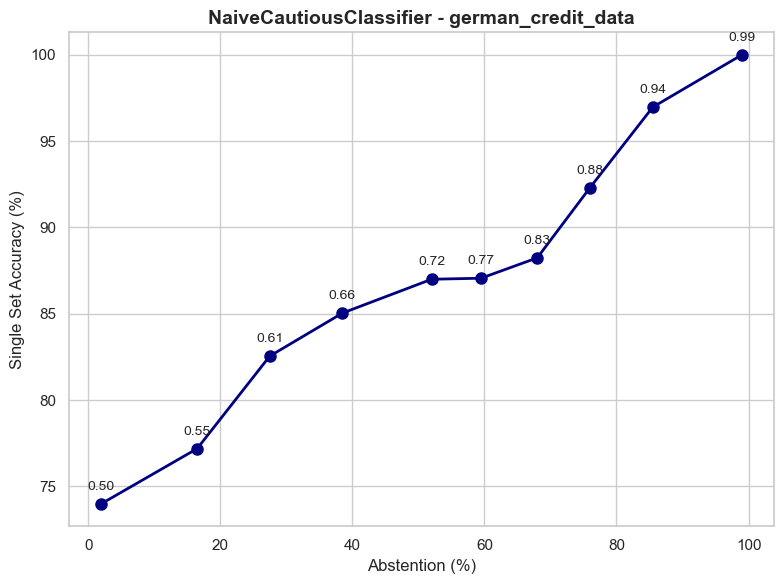

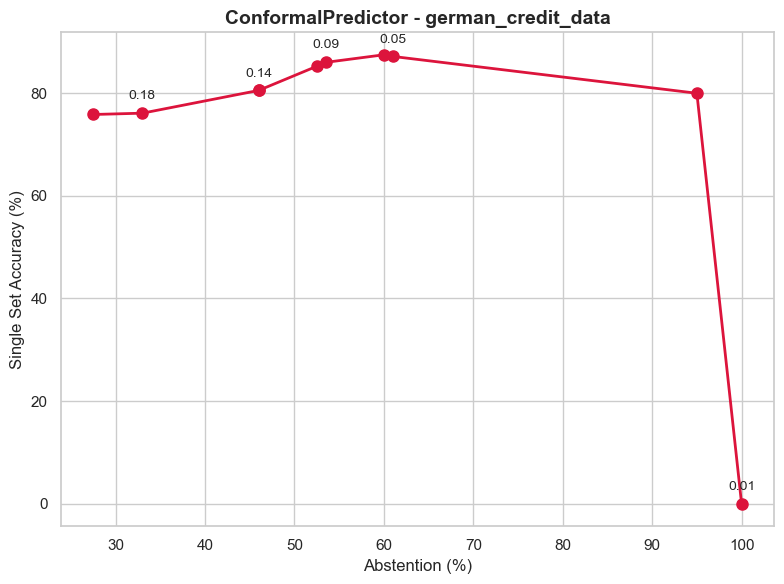

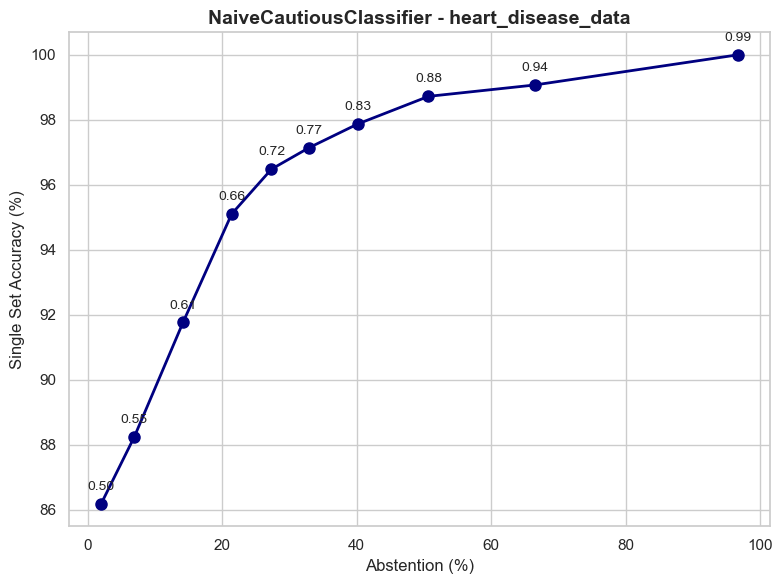

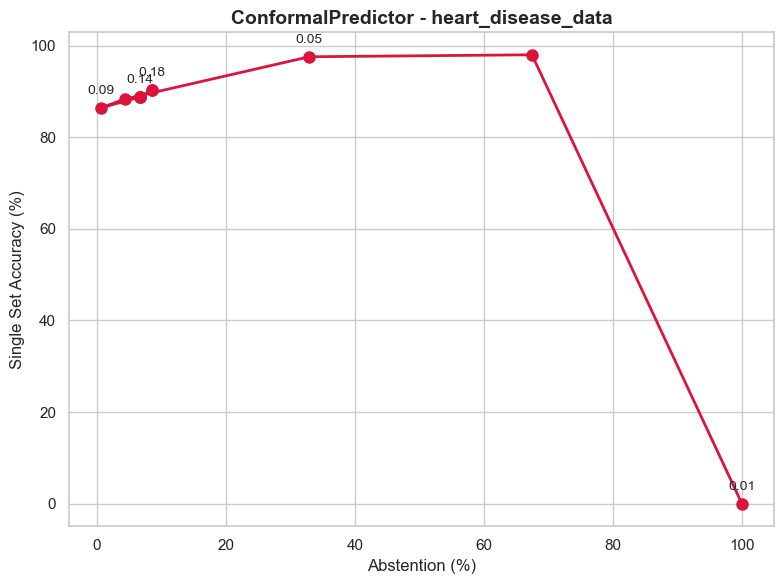

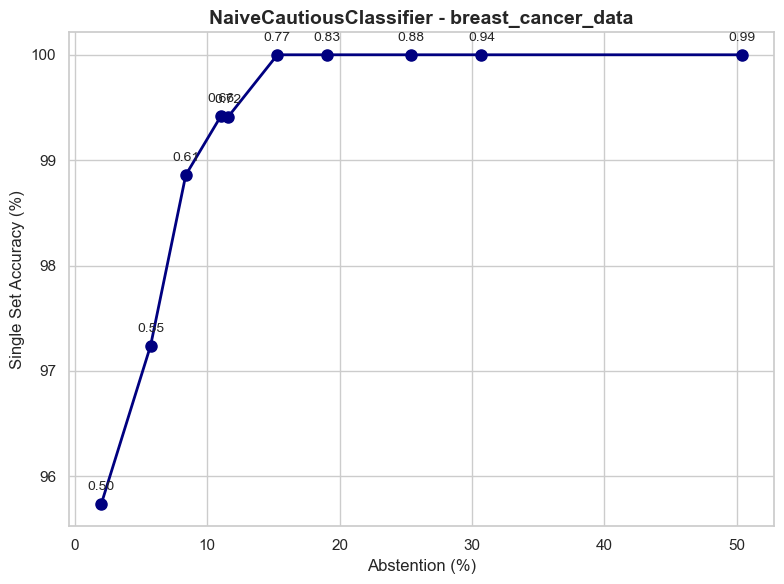

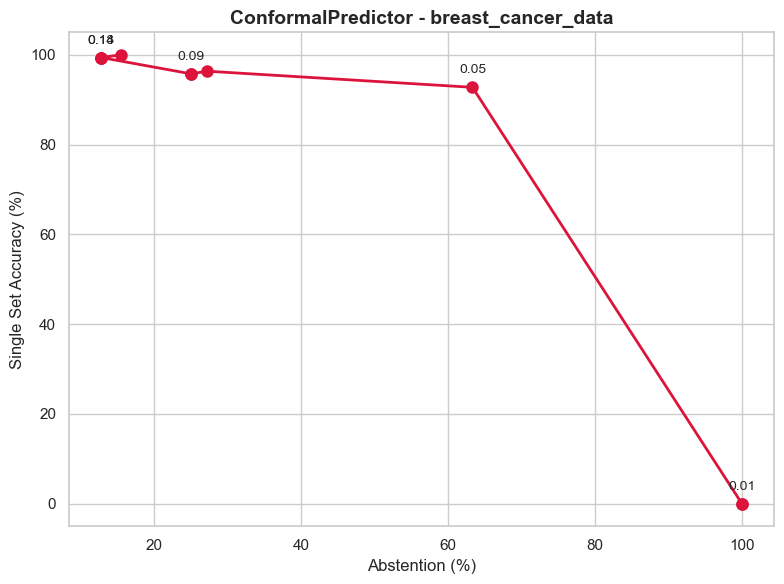

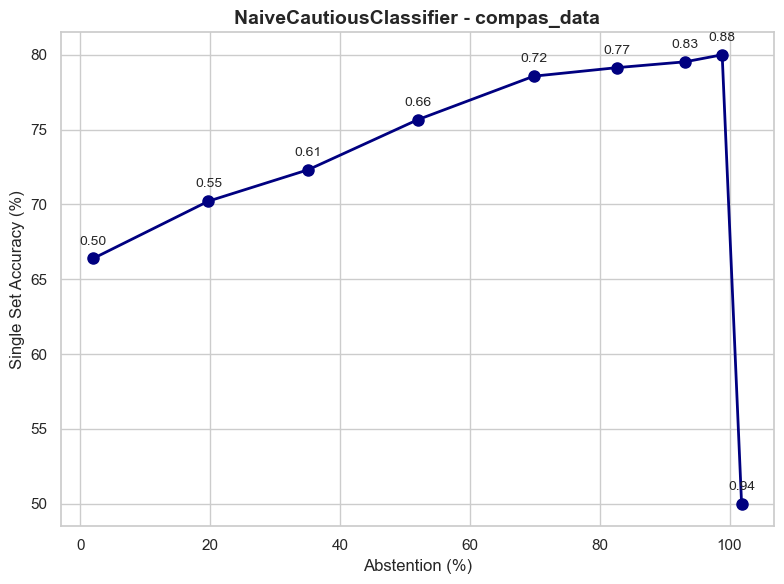

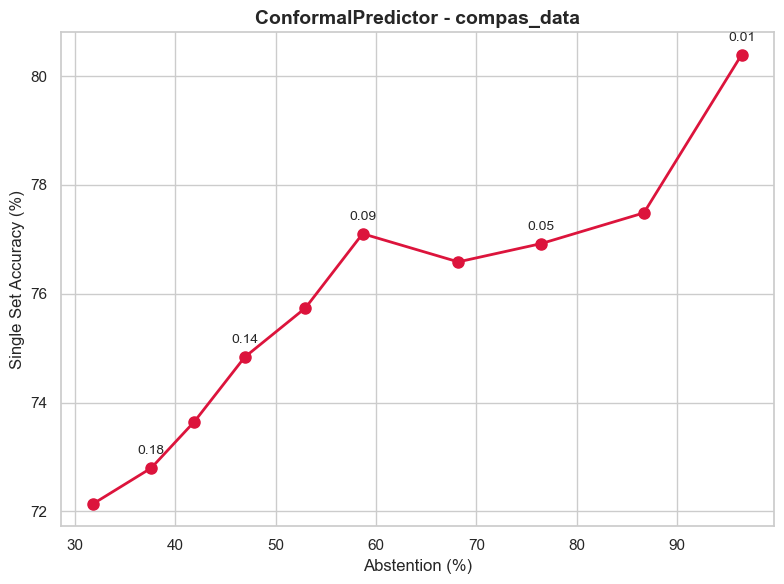

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracy_vs_abstention(experiment_results, dataset_name):
    sns.set_theme(style="whitegrid")  

    if dataset_name in experiment_results['NaiveCautiousClassifier']:
        fig, ax = plt.subplots(figsize=(8, 6))  
        abstention = experiment_results['NaiveCautiousClassifier'][dataset_name]['abstention']
        accuracy = experiment_results['NaiveCautiousClassifier'][dataset_name]['single_set_accuracy']
        thresholds = experiment_results['NaiveCautiousClassifier'][dataset_name]['thresholds']

        ax.plot(abstention, accuracy, marker='o', linestyle='-', linewidth=2, markersize=8, color='navy')
        ax.set_xlabel('Abstention (%)', fontsize=12)
        ax.set_ylabel('Single Set Accuracy (%)', fontsize=12)
        ax.set_title(f'NaiveCautiousClassifier - {dataset_name}', fontsize=14, fontweight='bold')

        for i, thresh in enumerate(thresholds):
            ax.annotate(f"{thresh:.2f}",
                        (abstention[i], accuracy[i]),
                        textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()

    if dataset_name in experiment_results['ConformalPredictor']:
        fig, ax = plt.subplots(figsize=(8, 6))
        abstention = experiment_results['ConformalPredictor'][dataset_name]['abstention']
        accuracy = experiment_results['ConformalPredictor'][dataset_name]['single_set_accuracy']
        alphas = experiment_results['ConformalPredictor'][dataset_name]['alphas']

        ax.plot(abstention, accuracy, marker='o', linestyle='-', linewidth=2, markersize=8, color='crimson')
        ax.set_xlabel('Abstention (%)', fontsize=12)
        ax.set_ylabel('Single Set Accuracy (%)', fontsize=12)
        ax.set_title(f'ConformalPredictor - {dataset_name}', fontsize=14, fontweight='bold')

        for i, alpha in enumerate(alphas):
            if i % 2 == 0:
                ax.annotate(f"{alpha:.2f}",
                            (abstention[i], accuracy[i]),
                            textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()

for dataset_name in DATASETS:
    plot_accuracy_vs_abstention(experiment_results, dataset_name)
